# Node2ToVec requirments

- choco install visualcpp-build-tools
- pip install --upgrade pip setuptools wheel
- pip install --upgrade gensim
- pip install scipy==1.12


In [3]:
pip install --upgrade pip setuptools wheel

# HTTPS://ONA-BOOK.ORG
#Handbook of Graphs and Networks in People Analytics: With Examples in R and Python


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade gensim


  Using cached gensim-4.3.2.tar.gz (23.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached scipy-1.14.0-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached smart_open-7.0.4-py3-none-any.whl.metadata (23 kB)
  Using cached wrapt-1.16.0-cp312-cp312-win_amd64.whl.metadata (6.8 kB)
Using cached scipy-1.14.0-cp312-cp312-win_amd64.whl (44.5 MB)
Using cached smart_open-7.0.4-py3-none-any.whl (61 kB)
Using cached wrapt-1.16.0-cp312-cp312-win_amd64.whl (37 kB)
  Created wheel for gensim: filename=gensim-4.3.2-cp312-cp312-win_amd64.whl size=23929533 sha256=d0d6776c2765e579e28c69cee65622086a55c94cac41bc596fdef6bc827a9cd1
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\50\c0\ac\7b

In [2]:
pip install scipy==1.12

  Using cached scipy-1.12.0-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached scipy-1.12.0-cp312-cp312-win_amd64.whl (45.8 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.0
    Uninstalling scipy-1.14.0:
      Successfully uninstalled scipy-1.14.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install pandas pyarrow networkx matplotlib  


Note: you may need to restart the kernel to use updated packages.


# Load Parquet file

Read the data from the parquet file into a DataFrame using the read_parquet function from the pandas library.

The data['Amount'] = data['Amount'].astype(float) line converts the 'Amount' column to a float data type.

The nodes dataframe are created using Carch_Check_No and Transaction_Type as nodes. A node feature is Node_Type to distinguish betwen Customer Node and Transaction Node.

The edge dataframe creates the links between Nodes [Customer, Transaction Type]. The edges featrures are the frequency, the mean and the sum of Amount. 



In [2]:
import pandas as pd
import numpy as np

parquet_file_path = "combined_data.parquet"
data = pd.read_parquet(parquet_file_path, engine='pyarrow')
data['Amount'] = data['Amount'].astype(float)



# Node DataFrames
data.dropna(subset=['Card_Check_No','Trans_Type','Card_Check_Type'], inplace=True)
data= data[data['Card_Check_No'].str.contains('^[0-9]')]

customer_nodes = data[['Card_Check_No']].drop_duplicates().reset_index(drop=True)
customer_nodes['Node_Type'] = 'Customer'

# Unique transaction types
transaction_type_nodes = data[['Trans_Type']].drop_duplicates().reset_index(drop=True)
transaction_type_nodes['Node_Type'] = 'Transaction_Type'


# Node DataFrame
nodes = pd.concat([customer_nodes, 
                   transaction_type_nodes.rename(columns={'Trans_Type': 'Card_Check_No'})],
                  ignore_index=True)

# Edge DataFrames
# Customer-Transaction Type Edges
customer_transaction_edges = data.groupby(['Card_Check_No', 'Trans_Type']).agg(
    Frequency=('Trans_Type', 'size'),
    Total_Amount=('Amount', 'sum'),
    Average_Amount=('Amount', 'mean')
).reset_index()
customer_transaction_edges['Edge_Type'] = 'Customer-Transaction_Type'


# Edge DataFrame
edges = pd.concat([customer_transaction_edges], ignore_index=True)



# Graph Construction

- Undirected graph is built using networkx
- It is visualized a subgraph of 300 nodes.
- Export the graph to gephi format  (graphhml)

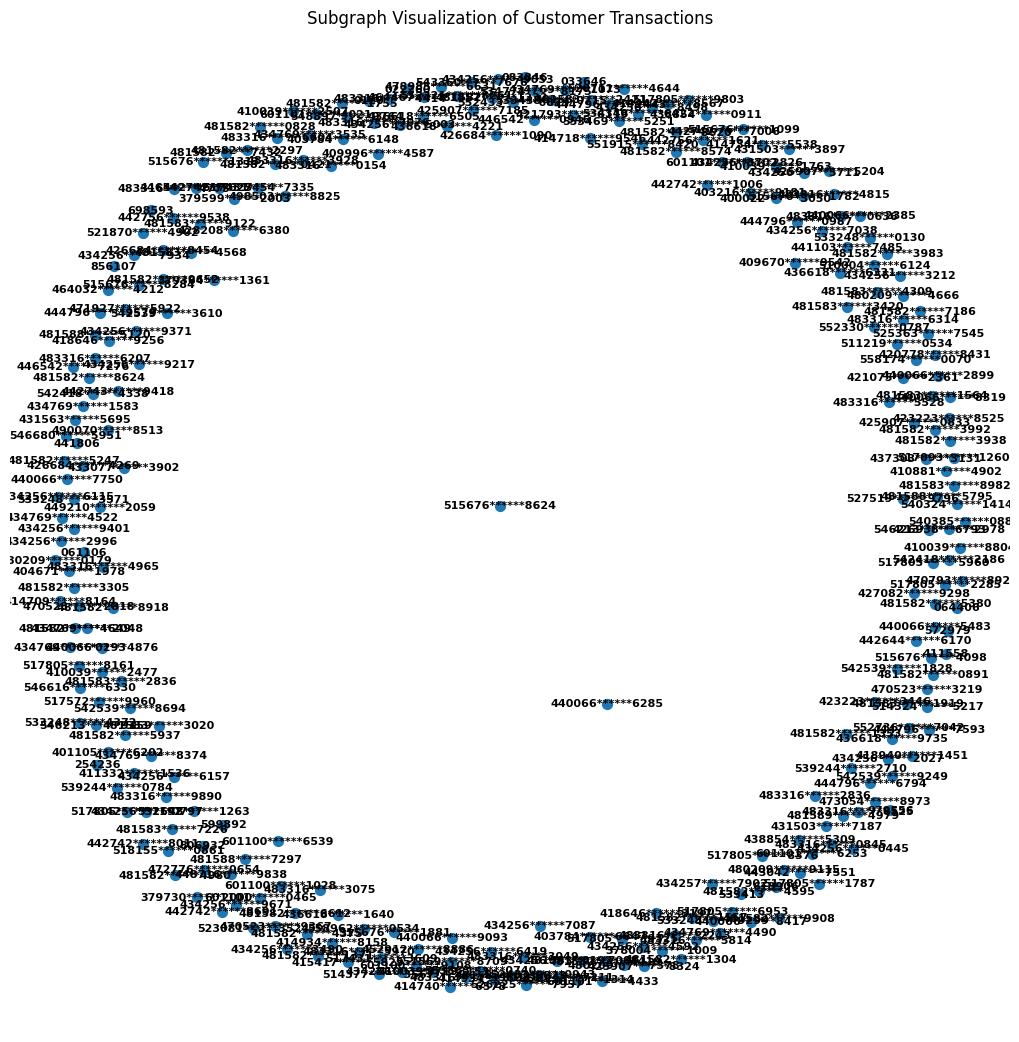

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

# Build the graph using NetworkX
G = nx.Graph()

# Add nodes
for index, row in nodes.iterrows():
    G.add_node(row['Card_Check_No'], Node_Type=row['Node_Type'])

# Add edges
for index, row in edges.iterrows():
    if row['Edge_Type'] == 'Customer-Transaction_Type':
        G.add_edge(row['Card_Check_No'], row['Trans_Type'], Frequency=row['Frequency'], 
                   Total_Amount=row['Total_Amount'], Average_Amount=row['Average_Amount'], 
                   Edge_Type=row['Edge_Type'])
    

# Visualize the graph
# Create a subgraph with a limited number of nodes
subgraph = G.subgraph(list(G.nodes)[:300])  


plt.figure(figsize=(10, 10))
pos = nx.spring_layout(subgraph, seed=42)  # Position nodes using the spring layout

nx.draw(subgraph, pos, with_labels=True, node_size=50, font_size=8, font_weight='bold')
plt.title("Subgraph Visualization of Customer Transactions")
plt.show()


# Export the graph to GraphML to be expoerted to Gephi
nx.write_graphml(G, "graph.graphml")


# Graph Properties

## Degree Centrality

Degree centrality is the simplest measure of node importance. It is defined as the number of edges incident to a node.The degree centrality of a node is the number of edges connected to it divided by the total number of nodes in the graph.

The degree centrality values are normalized to the range [0, 1].
The higher the degree centrality value, the more important the node is in the network.

When to use it: For finding very connected individuals, popular individuals, individuals who are likely to hold most information or individuals who can quickly connect with the wider network

Interpretation: The node with the identifier 434256******9217 is the most connected (in terms of direct edges) among all nodes classified as Customer, but its degree centrality is quite low (0.00003893550333871941). This suggests that Customer nodes are generally not very densely connected within the network.
The node with the identifier Debit is the most connected among all nodes classified as Transaction_Type, with a degree centrality value of 0.5275371347363093. This indicates that Debit nodes are much more densely connected compared to Customer nodes, implying that they play a more central role in the network's structure.


In [9]:
# Compute degree centrality
import random
def get_node_type(node):
    return G.nodes[node].get('Node_Type')

def get_max_degree_centrality(G, target_node_type):
    centrality = nx.degree_centrality(G)
    filtered_centrality = {node: centrality[node] for node in G.nodes if get_node_type(node) == target_node_type}
    max_node = max(filtered_centrality, key=filtered_centrality.get)
    max_value = filtered_centrality[max_node]
    return max_node, max_value

max_node, max_value = get_max_degree_centrality(G, 'Customer')
print(f"Node with maximum degree centrality for Customer Node: {max_node}")
print(f"Maximum degree centrality value for Customer Node: {max_value}")

max_node, max_value = get_max_degree_centrality(G, 'Transaction_Type')
print(f"Node with maximum degree centrality for Trans_Type Node: {max_node}")
print(f"Maximum degree centrality value for Trans_Type Node: {max_value}")




Node with maximum degree centrality for Customer Node: 434256******9217
Maximum degree centrality value for Customer Node: 3.893550333871941e-05
Node with maximum degree centrality for Trans_Type Node: Debit
Maximum degree centrality value for Trans_Type Node: 0.5275371347363093


# Betweenness Centrality

Betweenness centrality measures the number of times a node acts as a bridge along the shortest path between two other nodes.

The betweenness centrality of a node is the sum of the fraction of all-pairs shortest paths that pass through the node.

The betweenness centrality values are normalized to the range [0, 1].

The higher the betweenness centrality value, the more important the node is in the network.

When to use it: For finding the individuals who influence the flow around a system. It is useful for identifying individuals who control the flow of information in a network.

Interpretation:

The fact that the maximum betweenness centrality value for both Customer and Transaction_Type nodes is 0.0 suggests that within this network:

Customer nodes are not central in terms of connecting other nodes. They do not serve as bridges or intermediaries in the shortest paths between other nodes.
Similarly, Transaction_Type nodes also do not act as bridges in the network.
Possible Explanations:
Network Structure: The network might be such that nodes of these types are on the periphery or isolated, meaning they do not fall on the shortest paths between other nodes.
Role of Nodes: The roles or functions of Customer and Transaction_Type nodes may inherently be such that they are not meant to be central connectors in the network.

In [14]:
# Compute betweenness centrality

def get_max_betweenness_centrality(G, target_node_type):
    centrality = nx.betweenness_centrality(G)
    filtered_centrality = {node: centrality[node] for node in G.nodes if get_node_type(node) == target_node_type}
    # Find the node with the maximum betweenness centrality
    max_node = max(filtered_centrality, key=filtered_centrality.get)
    max_value = filtered_centrality[max_node]
    return max_node, max_value

def get_random_sample_of_node_type(G, target_node_type, sample_size):
    # Filter nodes by the target node type
    filtered_nodes = [node for node in G.nodes if get_node_type(node) == target_node_type]
    # Get a random sample from the filtered nodes
    if len(filtered_nodes) < sample_size:
        return filtered_nodes
    return random.sample(filtered_nodes, sample_size)

subgraph = G.subgraph(list(G.nodes)[:1000])  
max_node, max_value = get_max_betweenness_centrality(subgraph, 'Customer')
print(f"Node with maximum betweenness centrality for Customer Node: {max_node}")
print(f"Maximum betweenness centrality value for Customer Node: {max_value}")

subgraph = G.subgraph(get_random_sample_of_node_type(G, 'Transaction_Type', 1000))  
max_node, max_value = get_max_betweenness_centrality(subgraph, 'Transaction_Type')
print(f"Node with maximum betweenness centrality for Transaction_Type Node: {max_node}")
print(f"Maximum betweenness centrality value for Transaction_Type Node: {max_value}")

Node with maximum betweenness centrality for Customer Node: 434256******7934
Maximum betweenness centrality value for Customer Node: 0.0
Node with maximum betweenness centrality for Transaction_Type Node: Debit
Maximum betweenness centrality value for Transaction_Type Node: 0.0


# Closeness centrality

Closeness centrality measures how close a node is to all other nodes in the network.

When to use it: For finding the individuals who are best placed to influence the entire network most quickly. Closeness centrality can help find good ‘broadcasters’, but in a highly-connected network, you will often find all nodes have a similar score. 
What may be more useful is using Closeness to find influencers in a single cluster.


Interpretation:

Disconnected Components: The graph may have multiple disconnected components, causing some nodes to be isolated from the rest of the network.

Node Roles: The roles of Customer and Transaction_Type nodes might inherently involve limited connectivity, possibly due to how the network was constructed or the nature of the relationships being modeled.

Graph Structure: The overall structure of the graph might lead to certain types of nodes being less central or more peripheral

In [18]:
#Compute closeness centrality

def get_max_closeness_centrality(G, target_node_type):
    # Compute closeness centrality
    centrality = nx.closeness_centrality(G)
    # Filter the nodes based on the target node type
    filtered_centrality = {node: centrality[node] for node in G.nodes if get_node_type(node) == target_node_type}
    # Find the node with the maximum closeness centrality
    max_node = max(filtered_centrality, key=filtered_centrality.get)
    max_value = filtered_centrality[max_node]
    return max_node, max_value

subgraph = G.subgraph(list(G.nodes)[:1000]) 
max_node, max_value = get_max_closeness_centrality(subgraph, 'Customer')
print(f"Node with maximum closeness centrality for Customer Node: {max_node}")
print(f"Maximum closeness centrality value for Customer Node: {max_value}")

subgraph = G.subgraph(get_random_sample_of_node_type(G, 'Transaction_Type', 1000))  
max_node, max_value = get_max_closeness_centrality(subgraph, 'Transaction_Type')
print(f"Node with maximum closeness centrality for Transaction_Type Node: {max_node}")
print(f"Maximum closeness centrality value for Transaction_Type Node: {max_value}")

Node with maximum closeness centrality for Customer Node: 434256******7934
Maximum closeness centrality value for Customer Node: 0.0
Node with maximum closeness centrality for Transaction_Type Node: Debit
Maximum closeness centrality value for Transaction_Type Node: 0.0


# Eigenvector centrality

Eigenvector centrality is a measure of the influence of a node in a network. 

The eigenvector centrality of a node is the weighted sum of the centrality of its neighbors.

Eigenvector centrality is a measure of the influence of a node in a network.

What it tells us: By calculating the extended connections of a node, EigenCentrality can identify nodes with influence over the whole network, not just those directly connected to it.



Transaction_Type Node (Debit): This node has a high eigenvector centrality value, indicating it is a highly influential node within the network. It plays a key role in the connectivity and influence of the network, likely due to its connections with other important nodes.

Role in the Network: Transaction_Type nodes, particularly the Debit node, likely play a more critical role in the network's structure and function compared to Customer nodes. This could be due to the nature of transactions being central to network interactions.
Network Structure: The network may be structured in such a way that Transaction_Type nodes are more interconnected and central, while Customer nodes are more peripheral or less connected.
Connectivity and Influence: The high eigenvector centrality of the Debit node indicates it is a hub or a key node that other important nodes are connected to, enhancing its overall influence.


In [20]:
#Compute eigencentrality



def get_max_eigenvector_centrality(G, target_node_type):
    # Compute eigenvector centrality
    centrality = nx.eigenvector_centrality(G)
    # Filter the nodes based on the target node type
    filtered_centrality = {node: centrality[node] for node in G.nodes if get_node_type(node) == target_node_type}
    # Find the node with the maximum eigenvector centrality
    max_node = max(filtered_centrality, key=filtered_centrality.get)
    max_value = filtered_centrality[max_node]
    return max_node, max_value

subgraph = G.subgraph(list(G.nodes)[:1000]) 
max_node, max_value = get_max_eigenvector_centrality(subgraph, 'Customer')
print(f"Node with maximum eigenvector centrality for Customer Node: {max_node}")
print(f"Maximum eigenvector centrality value for Customer Node: {max_value}")

subgraph = G.subgraph(get_random_sample_of_node_type(G, 'Transaction_Type', 1000))  
max_node, max_value = get_max_eigenvector_centrality(subgraph, 'Transaction_Type')
print(f"Node with maximum eigenvector centrality for Transaction_Type Node: {max_node}")
print(f"Maximum eigenvector centrality value for Transaction_Type Node: {max_value}")




Node with maximum eigenvector centrality for Customer Node: 434256******7934
Maximum eigenvector centrality value for Customer Node: 0.03162277660168379
Node with maximum eigenvector centrality for Transaction_Type Node: Debit
Maximum eigenvector centrality value for Transaction_Type Node: 0.5773502691896258


# Clustering and Assortivity

Network Structure: The network has no local clustering (no tightly knit groups or triangles), and its structure is hierarchical, with highly connected nodes linking to less connected ones. This could indicate a star-like or hub-and-spoke structure where central nodes play a crucial role in network connectivity.

Node Interactions: The absence of clustering and the strong disassortative mixing suggest that nodes do not form local groups and that connections are made across different degrees of connectivity. High-degree nodes (hubs) are critical for maintaining network cohesion by connecting to many low-degree nodes.

Hierarchical or Star Structure: The network may be designed or naturally structured to have a central hub with many peripheral nodes

In [23]:
# Compute the average clustering
print(f"Average Clustering {nx.average_clustering(G)}")  
# Compute assortativity coefficient
print (f"assortativity coefficient{nx.assortativity.attribute_assortativity_coefficient(G, 'Node_Type')}")  


Average Clustering 0.0
 assortativity coefficient-1.0


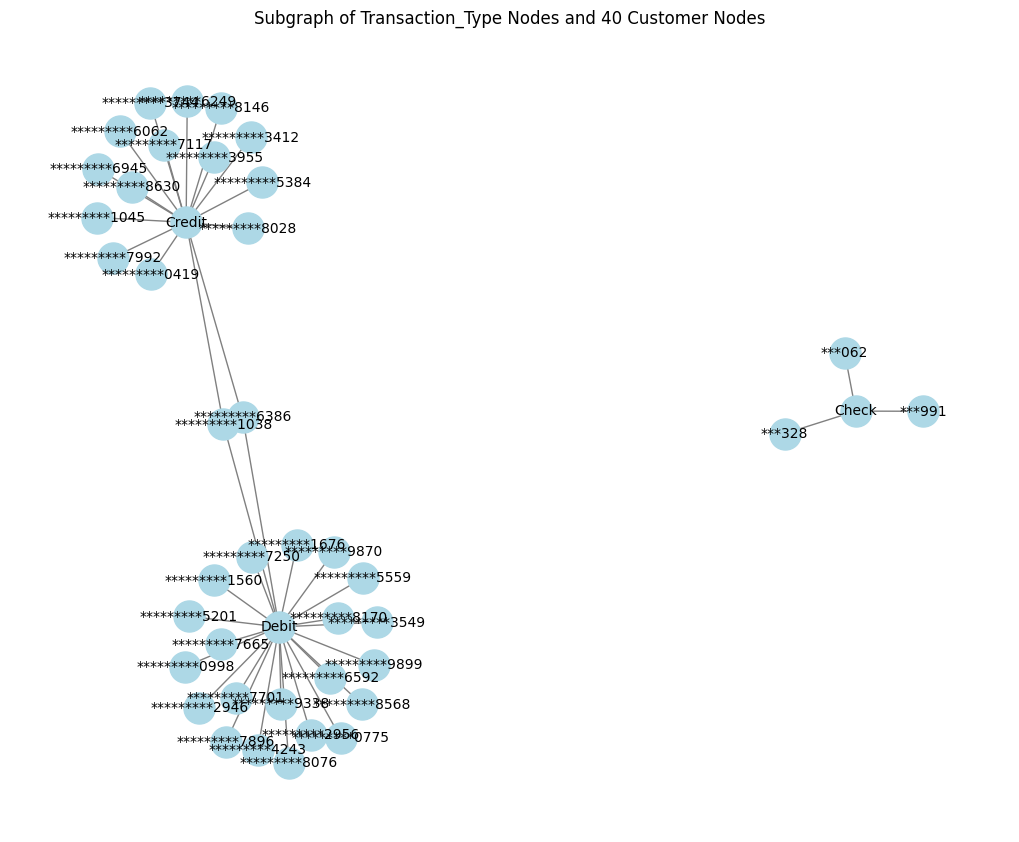

In [54]:
import random

def mask_card_check_no(card_check_no):
    # Ensure the input is a string and has the expected length
    card_check_no_str = str(card_check_no)
    if len(card_check_no_str) > 6:
        masked_card_check_no = '***' + card_check_no_str[6:]
    else:
        masked_card_check_no = '***' + card_check_no_str[3:]
    return masked_card_check_no


#Get all Transaction_Type nodes
transaction_type_nodes = [node for node in G.nodes if get_node_type(node) == 'Transaction_Type']

# Get a random sample of 40 Customer nodes
customer_sample_size = 40
customer_nodes = get_random_sample_of_node_type(G, 'Customer', customer_sample_size)
# Mask the Card_Check_No attribute for the sampled Customer nodes
    

# Combine both sets of nodes
selected_nodes = set(transaction_type_nodes + customer_nodes)

# Create a subgraph with the selected nodes
subgraph = G.subgraph(selected_nodes)
subgraph = nx.relabel_nodes(subgraph, {node: mask_card_check_no(node) for node in customer_nodes})

# Draw the subgraph
pos = nx.spring_layout(subgraph)  # Positioning of nodes
plt.figure(figsize=(10, 8))
nx.draw(subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)



plt.title('Subgraph of Transaction_Type Nodes and 40 Customer Nodes')
plt.show()

In [14]:
# Function to get max degree for each node type
def get_max_degree_by_node_type(G):
    max_degrees = {}
    attributes_by_type = {}
    for node in G.nodes:
        node_type = G.nodes[node].get('Node_Type')
        degree = G.degree[node]
        if node_type:
            if node_type not in max_degrees or degree > max_degrees[node_type]:
                max_degrees[node_type] = degree
                attributes_by_type[node_type] = {
                    'node': node,
                    'degree': degree}
    return max_degrees, attributes_by_type

# Get the max degrees
max_degrees_by_type,attributes_by_type  = get_max_degree_by_node_type(G)

# Print the results
print("Max Degrees by Node Type:", max_degrees_by_type)
print("Attributes by Node Type for Max Degree Nodes:", attributes_by_type)

Max Degrees by Node Type: {'Customer': 2, 'Transaction_Type': 27098}
Attributes by Node Type for Max Degree Nodes: {'Customer': {'node': '434256******9217', 'degree': 2}, 'Transaction_Type': {'node': 'Debit', 'degree': 27098}}


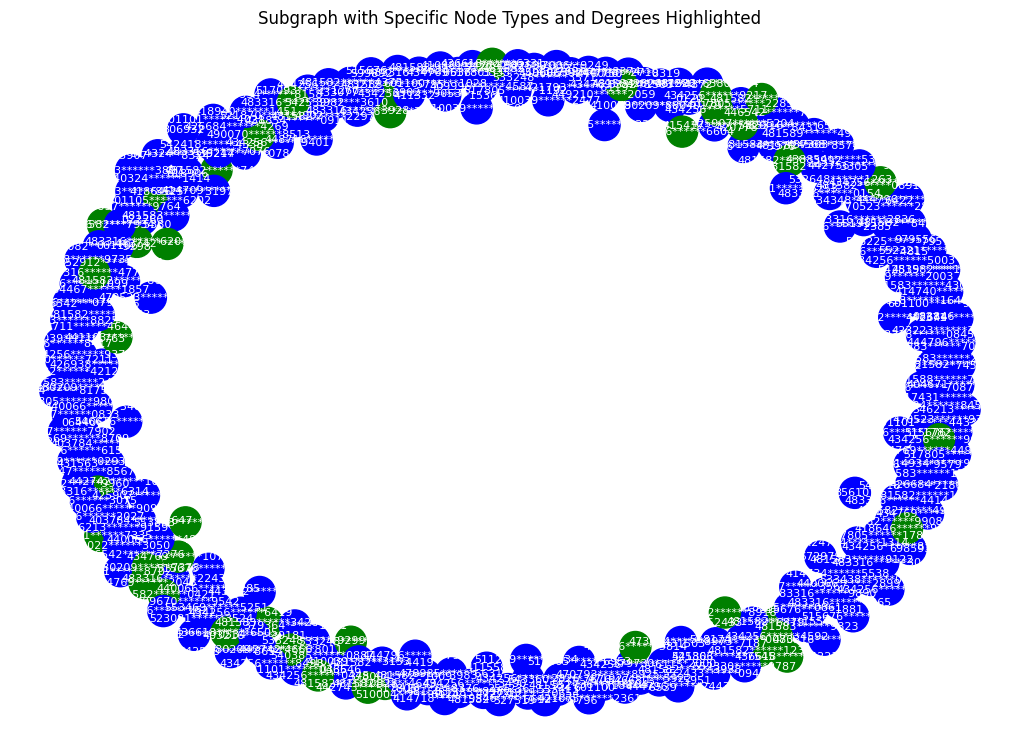

In [15]:
# Draw the subgraph with a layout
pos = nx.spring_layout(subgraph)

# Draw nodes
node_colors = []
for node in subgraph.nodes:
    if G.nodes[node]['Node_Type'] == 'Customer' and G.degree[node] == max_degrees_by_type['Customer']:
        node_colors.append('green')  # Highlight Customer nodes with degree 2 in green
    elif G.nodes[node]['Node_Type'] == 'Transaction_Type' and G.degree[node] == max_degrees_by_type['Transaction_Type']:
        node_colors.append('red')  # Highlight Transaction nodes with max degree in red
    else:
        node_colors.append('blue')

# Draw the subgraph
plt.figure(figsize=(10, 7))
nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=8, font_color='white')
plt.title('Subgraph with Specific Node Types and Degrees Highlighted')
plt.show()

In [16]:
pip install node2vec

Note: you may need to restart the kernel to use updated packages.


# Node Embeddings

In [17]:
from node2vec import Node2Vec

# Create a Node2Vec model
# explain the parameters
# dimensions: Dimensionality of the node2vec embeddings
# walk_length: Length of the random walk
# num_walks: Number of random walks to generate
# workers: Number of parallel processes

node2vec = Node2Vec(G, dimensions=2, walk_length=10, num_walks=100, workers=2)  # dimensions=2 for 2D visualization

# Fit the model 
# Explain the parameters
# window: Maximum distance between the current and predicted word within a sentence
# min_count: Ignores all words with total frequency lower than this
# batch_words: Target size (in words) for batches of examples passed to worker threads

model = node2vec.fit(window=10, min_count=1, batch_words=4)

embeddings = model.wv

# Print embeddings for each node
for node in G.nodes:
    print(f"Node {node}: {embeddings[str(node)]}")


Computing transition probabilities:  59%|█████▉    | 30560/51368 [53:11<30:51, 11.24it/s]  

In [7]:
G.nodes

NodeView((1, 2, 3, 4, 5, 6))